In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [ ]:
# Risk-free assets - U.S. Treasury Bond
risk_free_rate = 0.001
#Current Yield= Annual Interest/Current Market Price

In [ ]:
#10 Risky Assets
symbols = ["NVDA", "MSFT", "IBM", "AMZN", "GOOGL", "BLK", "JPM", "V", "DIS", "NFLX"]
start_date = '2023-10-01'
end_date = '2024-01-25'
stock_data = [yf.download(symbol, start=start_date, end=end_date)['Adj Close'] for symbol in symbols]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
# Daily returns for each stock
returns = [data.pct_change().dropna() for data in stock_data]
#
covariances = np.cov(returns)

In [ ]:
market = yf.download('^GSPC', start=start_date, end=end_date)['Adj Close']
market_returns = market.pct_change().dropna()

[*********************100%%**********************]  1 of 1 completed


In [ ]:
betas = [returns[i].cov(market_returns) / market_returns.var() for i in range(len(symbols))]

In [ ]:
expected_market_return = market_returns.mean()

In [ ]:
# Expected returns using CAPM
expected_returns = np.array([risk_free_rate + beta * (expected_market_return - risk_free_rate) for beta in betas])

In [ ]:
expected_returns_df = pd.DataFrame({
    'Asset': symbols,
    'Beta': betas,
    'Expected_Return': expected_returns
})

print(expected_returns_df)

   Asset      Beta  Expected_Return
0   NVDA  1.850737         0.001362
1   MSFT  0.868069         0.001701
2    IBM  0.492331         0.001830
3   AMZN  1.473351         0.001492
4  GOOGL  1.339299         0.001538
5    BLK  1.322354         0.001544
6    JPM  0.673372         0.001768
7      V  0.717646         0.001753
8    DIS  0.798222         0.001725
9   NFLX  0.752126         0.001741


In [ ]:
np.array(returns).mean(axis = 1)

array([0.00427721, 0.00297336, 0.00290595, 0.00261546, 0.00146715,
       0.00275785, 0.0024014 , 0.00212294, 0.0019027 , 0.0049435 ])

In [ ]:
def optimal_portfolio(corr, mean, risk, short_selling = False):
  # objective function
  def objective(W):
      return -np.dot(mean.T, W)  # negative sign for maximization
  O = np.ones((10, 1))
  # Define the constraints
  cons = ({'type': 'eq', 'fun': lambda W: np.dot(W.T, O) - 1},
          {'type': 'eq', 'fun': lambda W: np.dot(np.dot(W.T, corr), W) - risk})
  # Bounds for the weights
  if(short_selling == False):
    bounds = tuple((0.01, 1) for i in range(10))
  else:
    bounds = tuple((None, None) for i in range(10))
  x0 = np.ones(10)*0.1 # Initially assigning equal weights
  result = minimize(objective, x0, method='SLSQP', bounds=bounds, constraints=cons)
  return result.x

def returns(stock_prices):
  stock_prices = np.array(stock_prices)
  stock_returns = np.diff(stock_prices) / stock_prices[:-1]
  return stock_returns
def mean_variance(stock_returns):
  return np.mean(stock_returns), np.var(stock_returns)



In [ ]:
symbols = ["NVDA", "MSFT", "IBM", "AMZN", "GOOGL", "BLK", "JPM", "V", "DIS", "NFLX"]
start_date = '2023-10-01'
end_date = '2024-01-25'
stock_data = [yf.download(symbol, start=start_date, end=end_date) for symbol in symbols]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
df = pd.DataFrame()
for i in range(10):
  df[symbols[i]] = stock_data[i]["Close"]


In [ ]:
stock_returns = df.pct_change().dropna()
return_means, return_variance, corr_matrix = stock_returns.mean(), stock_returns.var(), stock_returns.corr()

In [ ]:
risk_var = np.linspace(0.27245545, 0.5, 100) # Risk
# y = results_var
returns = [] # Returns
for risk in risk_var:
  opt_w = optimal_portfolio(corr_matrix, return_means, risk)
  max_return = np.dot(return_means.T, opt_w)
  returns.append(max_return)
risk_std = np.sqrt(risk_var)
plt.scatter(risk_std, returns)
plt.ylabel("Return")
plt.xlabel("Risk")
plt.title("Effecient Frontier without Short Selling")

In [ ]:
sharpe_ratios = (np.array(returns) - 0.001) / np.array(risk_std)

In [ ]:
max_sharpe_idx = np.argmax(sharpe_ratios)
tangency_return = returns[max_sharpe_idx]
tangency_volatility = risk_std[max_sharpe_idx]

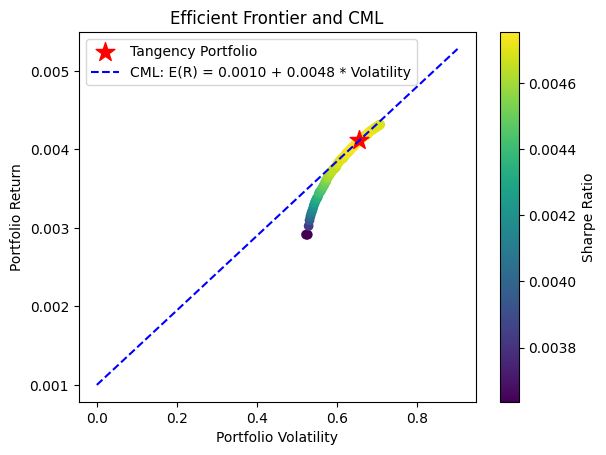

Tangency Point (Volatility, Return): (0.6548, 0.0041)


In [ ]:
# Plot the efficient frontier and CML
plt.scatter(risk_std, returns, c=sharpe_ratios, cmap='viridis', marker='o')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(tangency_volatility, tangency_return, marker='*', color='r', s=200, label='Tangency Portfolio')
plt.xlabel('Portfolio Volatility')
plt.ylabel('Portfolio Return')
plt.title('Efficient Frontier and CML')

# CML equation
cml_slope = (tangency_return - risk_free_rate) / tangency_volatility
cml_equation = f"CML: E(R) = {risk_free_rate:.4f} + {cml_slope:.4f} * Volatility"

# Plot CML
x_cml = np.linspace(0, 0.9, 100)
y_cml = risk_free_rate + cml_slope * x_cml
plt.plot(x_cml, y_cml, color='b', linestyle='--', label=cml_equation)

plt.legend()
plt.show()

# Print the tangency point and its significance
print(f"Tangency Point (Volatility, Return): ({tangency_volatility:.4f}, {tangency_return:.4f})")

#  Market Portfolio Wieghts

In [ ]:
opt_w = optimal_portfolio(corr_matrix, return_means, 0.6548**2)
opt_w

array([0.24157487, 0.01      , 0.20926271, 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01825085, 0.47091157])

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


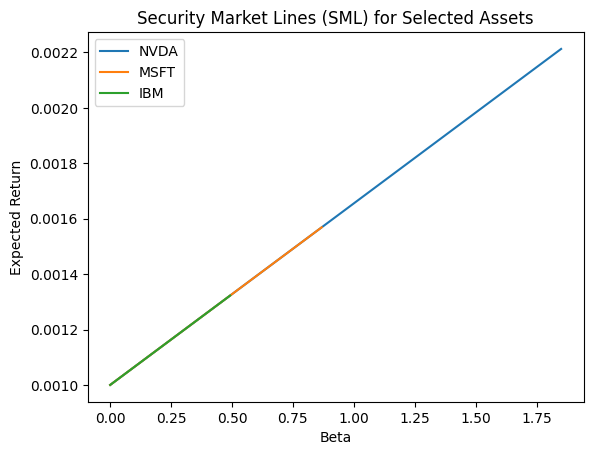

In [ ]:
symbols = ["NVDA", "MSFT", "IBM"]
start_date = '2023-10-01'
end_date = '2024-01-25'
risk_free_rate = 0.001


selected_data = [yf.download(symbol, start=start_date, end=end_date)['Adj Close'] for symbol in symbols]
# daily returns for each selected asset
selected_returns = [data.pct_change().dropna() for data in selected_data]

# beta for each selected asset
market_returns = yf.download('^GSPC', start=start_date, end=end_date)['Adj Close'].pct_change().dropna()
selected_betas = [selected_returns[i].cov(market_returns) / market_returns.var() for i in range(len(symbols))]

# expected returns using CAPM
selected_expected_returns = [risk_free_rate + beta * (expected_market_return - risk_free_rate) for beta in selected_betas]

# Plot individual Security Market Lines (SML)
for i in range(len(symbols)):
    plt.plot([0, selected_betas[i]], [risk_free_rate, selected_expected_returns[i]], label=symbols[i])
    # plt.show()

plt.xlabel('Beta')
plt.ylabel('Expected Return')
plt.title('Security Market Lines (SML) for Selected Assets')
plt.legend()
plt.show()

# New section

In [ ]:
risky_portfolio_return = np.dot(opt_w.T, return_means)
risky_portfolio_risk = np.dot(np.dot(opt_w.T, corr_matrix), opt_w)

In [ ]:

def portfolio_performance(w_risky, opt_w, risky_returns, risk_free_rate = 0.001, opt_risk = risky_portfolio_risk):
  returns = w_risky * np.dot(opt_w.T, risky_returns)  + (1 - w_risky)*(risk_free_rate)
  risk = (w_risky) * (opt_risk**0.5)
  return returns, risk, (returns - risk_free_rate)/risk

In [ ]:
w_r = np.linspace(0, 1, 100) # W_risky
portfolios = []
for w in w_r:
  portfolios.append(portfolio_performance(w, opt_w, return_means))



<ipython-input-54-2933518b6abc>:4: RuntimeWarning: invalid value encountered in scalar divide
  return returns, risk, (returns - risk_free_rate)/risk


In [ ]:
portfolios = np.array(portfolios)
portfolios

Tangency Point (Volatility, Return): (0.6548, 0.0041)


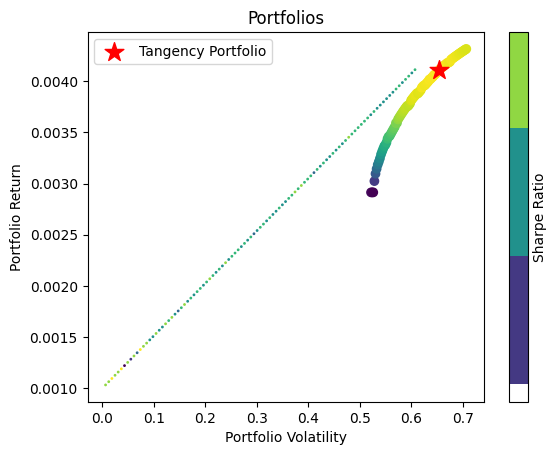

In [ ]:
# Plot the efficient frontier and CML
plt.scatter(portfolios[:, 1], portfolios[:, 0], c=portfolios[:, 2], cmap='viridis', marker='o', s = 1)
plt.colorbar(label='Sharpe Ratio')
# plt.scatter(tangency_volatility, tangency_return, marker='*', color='r', s=200, label='Tangency Portfolio')
plt.xlabel('Portfolio Volatility')
plt.ylabel('Portfolio Return')
plt.title('Portfolios')

# Plot the efficient frontier and CML
plt.scatter(risk_std, returns, c=sharpe_ratios, cmap='viridis', marker='o')
# plt.colorbar(label='Sharpe Ratio')
plt.scatter(tangency_volatility, tangency_return, marker='*', color='r', s=200, label='Tangency Portfolio')

# Print the tangency point and its significance
print(f"Tangency Point (Volatility, Return): ({tangency_volatility:.4f}, {tangency_return:.4f})")
plt.legend()
plt.show()
